In [1]:
!pip install datasets seaborn

You should consider upgrading via the '/home/jmperez/projects/hatespeech-classification/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
from datasets import load_dataset

dataset = load_dataset("piubamas/articles_and_comments")

Using custom data configuration piubamas___articles_and_comments-ce16420144f58fd7
Reusing dataset parquet (/home/jmperez/.cache/huggingface/datasets/parquet/piubamas___articles_and_comments-ce16420144f58fd7/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:

len(dataset["train"])

537201

Viene siempre esto con varios "splits" ("train", y otros usualmente). Acá en realidad el dataset tiene sólo train, así que usamos esto

In [4]:
ds = dataset["train"]

Para ver el primer elemento del dataset, hacemos:


In [5]:
ds[0]

{'tweet_id': '1376940813968609288',
 'text': 'Segunda ola de coronavirus: preocupan las reuniones sociales y el Gobierno analiza medidas para después de Semana Santa https://t.co/KG2XU0uRKz',
 'title': 'Segunda ola de coronavirus: preocupan las reuniones sociales y el Gobierno analiza medidas para después de Semana Santa',
 'url': 'https://www.clarin.com/politica/segunda-ola-coronavirus-preocupan-reuniones-sociales-gobierno-analiza-medidas-despues-semana-santa_0_NnjHl1iUe.html?utm_medium=Social&utm_source=Twitter#Echobox=1617123246',
 'user': 'clarincom',
 'body': 'La decisión de Axel Kicillof de suspender actividades nocturnas y limitar las reuniones sociales no sorprendió a la Casa Rosada. Más allá de que había avisado que tomaría medidas restrictivas, el gobernador bonaerense se adelantó a la primera herramienta a la que apelaría la administración de Alberto Fernández después de Semana Santa si es que la curva de contagios sigue en ascenso.\n\nLa confirmación de que en Argentina ya 

Podemos ver qué elementos tiene una noticia con

In [6]:
example = ds[0]

example.keys()

dict_keys(['tweet_id', 'text', 'title', 'url', 'user', 'body', 'created_at', 'comments'])

¿Qué tienen los comentarios?


In [7]:
comments = example["comments"]

comments[0]

{'created_at': '2021-03-30T17:03:09Z',
 'prediction': {'APPEARANCE': 0,
  'CALLS': 0,
  'CLASS': 0,
  'CRIMINAL': 0,
  'DISABLED': 0,
  'LGBTI': 0,
  'POLITICS': 0,
  'RACISM': 0,
  'WOMEN': 0},
 'text': '@clarincom A mi me preocupa el trabajo.. La evita madre que los pario 😵',
 'tweet_id': '1376943088732672004',
 'user_id': '1532596098'}

En `prediction` tenemos la salida del clasificador corrido para cada par (noticia, comentario)

Para recorrer todas las noticias, hacemos algo así:


In [8]:
from datetime import datetime
from tqdm.auto import tqdm
from collections import Counter

# Contamos cantidad de noticias
counter = Counter()
# Recolectamos fechas
dates = []

for ex in tqdm(dataset["train"]):
    counter[ex["user"]] += 1
    
    date = ex["created_at"]
    # Convertimos la fecha a un objeto de python
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%fZ")
    dates.append({"user": ex["user"], "date": date})


  0%|          | 0/537201 [00:00<?, ?it/s]

Tarda un poquito, pero bueno, son 500k noticias :-) 

In [9]:
# Esto los ordena de mayor a menor
counter.most_common(25)

[('infobae', 98777),
 ('clarincom', 66278),
 ('abc_es', 54106),
 ('LANACION', 51566),
 ('cronica', 50372),
 ('latercera', 48003),
 ('elmundoes', 45106),
 ('elpaisuy', 29958),
 ('pagina12', 29210),
 ('LaVanguardia', 29025),
 ('perfilcom', 21088),
 ('izquierdadiario', 8008),
 ('laderechadiario', 2904),
 ('laderechamedios', 2800)]

(array([18170., 18262., 18353., 18444., 18536., 18628., 18718., 18809.,
        18901.]),
 [Text(18170.0, 0, '2019-10'),
  Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10')])

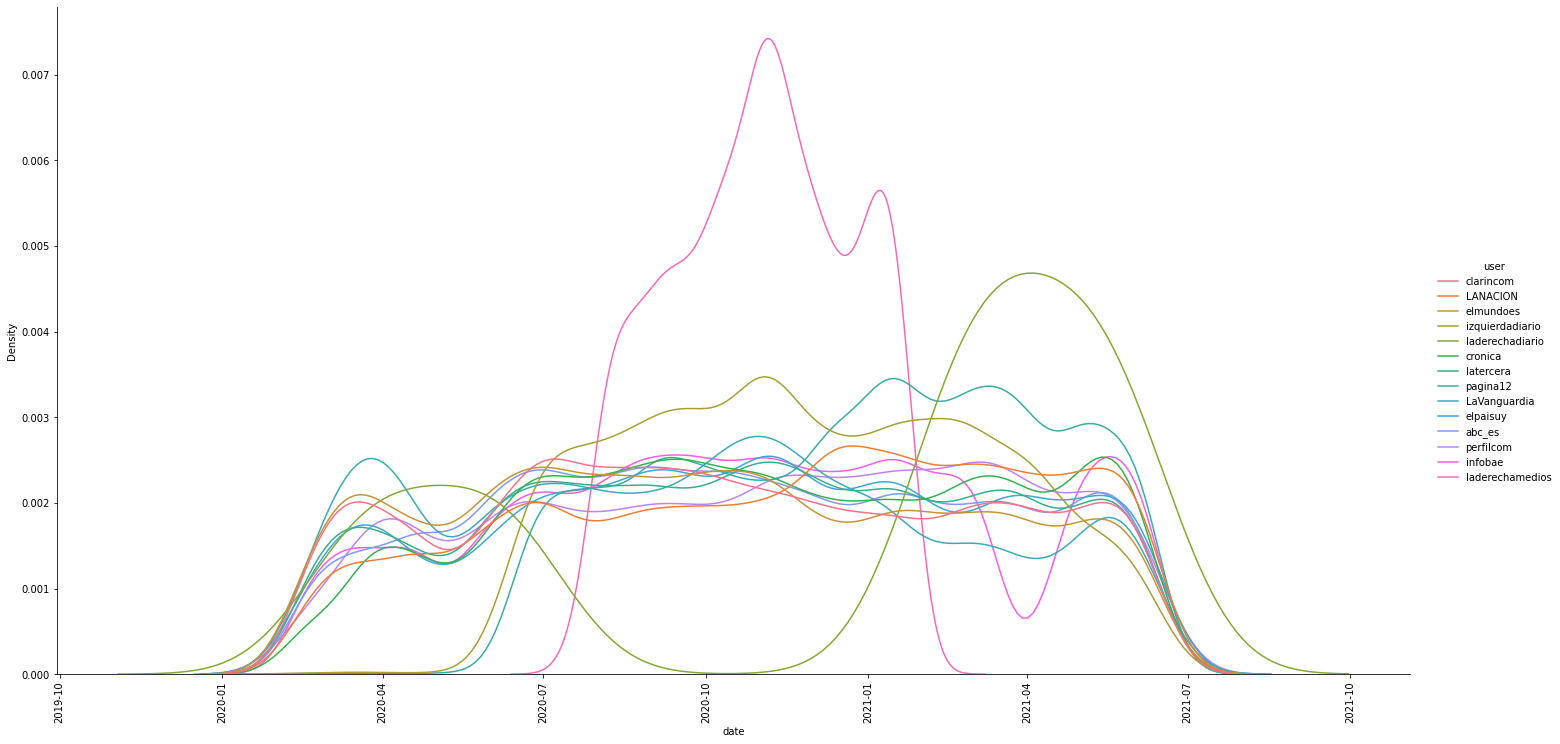

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dates_df = pd.DataFrame(dates)



sns.displot(data=dates_df, x="date", hue="user", height=10, aspect=2, kind="kde", common_norm=False)

# Twist ticks

plt.xticks(rotation=90)

## Comentarios con discurso de odio

Agreguemos al dataset la cantidad de comentarios con discurso de odio


In [11]:
labels = [
    'CALLS',
    'CLASS',
    'CRIMINAL',
    'DISABLED',
    'LGBTI',
    'POLITICS',
    'RACISM',
    'WOMEN'
]

def count_labels(example):
    counter = {label: 0 for label in labels}
    for comment in example["comments"]:
        for label in labels:
            counter[label] += comment["prediction"][label]
    return counter

count_labels(ds[2])

{'CALLS': 1,
 'CLASS': 0,
 'CRIMINAL': 0,
 'DISABLED': 0,
 'LGBTI': 1,
 'POLITICS': 30,
 'RACISM': 4,
 'WOMEN': 0}

El ejemplo número 2 tiene 30 comentarios discriminatorios por temas políticos, veamos

In [12]:
ds[2]

{'tweet_id': '1376941040205238272',
 'text': 'Pablo Iglesias se encara a un grupo de ultraderecha que le esperaba en Coslada https://t.co/bOgZGP0Q3v',
 'title': None,
 'url': None,
 'user': 'elmundoes',
 'body': None,
 'created_at': '2021-03-30T16:55:00Z',
 'comments': [{'created_at': '2021-03-30T16:56:29Z',
   'prediction': {'APPEARANCE': 0,
    'CALLS': 0,
    'CLASS': 0,
    'CRIMINAL': 0,
    'DISABLED': 0,
    'LGBTI': 0,
    'POLITICS': 0,
    'RACISM': 0,
    'WOMEN': 0},
   'text': '@elmundoes Con guardaespaldas jajajaja. Qué valiente.',
   'tweet_id': '1376941409815646213',
   'user_id': '131570932'},
  {'created_at': '2021-03-30T16:57:18Z',
   'prediction': {'APPEARANCE': 0,
    'CALLS': 0,
    'CLASS': 0,
    'CRIMINAL': 0,
    'DISABLED': 0,
    'LGBTI': 0,
    'POLITICS': 0,
    'RACISM': 0,
    'WOMEN': 0},
   'text': '@elmundoes Con los escoltas',
   'tweet_id': '1376941616171257856',
   'user_id': '1280338634'},
  {'created_at': '2021-03-30T16:57:20Z',
   'prediction': 

Mmmmm.... 

In [13]:
# Es una forma medio rara esta, pero básicamente "agrega" las columnas que estamos devolviendo en la función
ds = ds.map(count_labels)

  0%|          | 0/537201 [00:00<?, ?ex/s]

In [14]:
ds[10]

{'tweet_id': '1376943984631816193',
 'text': '“Caminemos juntas como siempre”, el conmovedor poema que Josefina Sarkany le escribió a su hermana Sofía https://t.co/6ENzOb9EHO https://t.co/h7igExk1V4',
 'title': '“Caminemos juntas como siempre”, el conmovedor poema que Josefina Sarkany le escribió a su hermana Sofía',
 'url': 'https://www.lanacion.com.ar/espectaculos/personajes/caminemos-juntas-como-siempre-el-conmovedor-poema-que-josefina-sarkany-le-escribio-a-su-hermana-nid30032021/?utm_term=Autofeed&utm_medium=Echobox&utm_source=Twitter#Echobox=1617116574',
 'user': 'LANACION',
 'body': 'Mientras la familia Sarkany sigue recibiendo mensajes de dolor y cariño por la muerte de la joven , su hermana Josefina le rindió un sentido homenaje en sus redes sociales con un poema conmovedor.\n\n“Te voy a extrañar tanto tanto tanto. Toda mi vida. Gracias por esta hermosa vida compartida. Fuiste sos y serás mi hermana y mejor amiga. Y ahora, cómo me dijiste, ambas guardianas de nuestros bebés”, e